# Minimum Sliced-Wasserstein Estimators for Multivariate Gaussian distributions

In this notebook, we consider the task of estimating the parameters of a multivariate Gaussian distribution using the minimum Sliced-Wasserstein estimator (MSWE) and minimum expected Sliced-Wasserstein estimator (MESWE). The goal is to empirically validate the rate of convergence of MSWE of order 1 (Theorem 6, [1]), the consistency of MSWE (Theorem 2, [1]) and MESWE (Theorem 3, [1]), and the convergence of MESWE to MSWE (Theorem 4, [1]).

The target is a 10-dimensional Gaussian distribution $\mathcal{N}(\mathbf{m}_\star, \sigma_\star^2 I)$, where $\mathbf{m}_\star = \mathbf{0}$ and $\sigma_\star = 1$. We generate $n$ i.i.d. observations from the target distribution, and denote its empirical distribution by $\hat{\mu}_n$. The objective of MSWE is:

\begin{align}
   \hat{\mathbf{m}}_n, \hat{\sigma}_n = \text{argmin}_{\mathbf{m}, \sigma}\ \textbf{SW}_2 \big(\hat{\mu}_n, \mathcal{N}(\mathbf{m}, \sigma^2 \mathbf{I}) \big)
\end{align}

Regarding MESWE, we generate $m$ i.i.d. samples of $\mathcal{N}(\mathbf{m}, \sigma^2 \mathbf{I})$ and denote its empirical distribution by $\hat{\mu}_{(\mathbf{m}, \sigma), m}$. The objective of MESWE is:

\begin{align}
   \hat{\mathbf{m}}_{n,m},\hat{\sigma}_{n,m}  = \text{argmin}_{\mathbf{m}, \sigma}\ \mathbb{E} \big[ \textbf{SW}_2 \big(\hat{\mu}_n, \hat{\mu}_{(\mathbf{m}, \sigma), m} \big) \big],
\end{align}

where the expectation is taken with respect to the different sets of $m$ samples drawn from $\mathcal{N}(\mathbf{m}, \sigma^2 \mathbf{I})$.


#### Requirements
- Numpy
- Scipy
- Matplotlib
- IPython Parallel (for parallel computing)

#### Reference
[1] Kimia Nadjahi, Alain Durmus, Umut Şimşekli, Roland Badeau. *Asymptotic Guarantees for Learning Generative Models with the Sliced-Wasserstein Distance.* NeurIPS 2019.

In [1]:
import numpy as np
import os
from tqdm import tqdm
from ipyparallel import Client
from time import time
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
# Create the repository that will contain the figures
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
# Configuration of IPython Parallel
rc = Client()
dv = rc[:]

In [4]:
# Parameters of the target Gaussian distribution
dim = 10
m_star = np.zeros(dim)
sigma_star = 1.

### Illustration of the Central Limit Theorem for MSWE

For different values of $n$, we draw $n$ samples from the target distribution and compute the (approximate) MSWE of order 1. We repeat this experiment several times and we plot the density of $\sqrt{n}(\hat{\sigma}_n - \sigma_\star)$, estimated with a kernel density estimator (`gaussian_kde` from `scipy.stats`).

In [5]:
# This function generates 'n_samples' observations from the target and returns the MSWE of order 1
def compute_mswe(n_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators

    # Parameters of the target Gaussian distribution
    dim = 10  # dimension
    m_star = np.zeros(dim)  # true mean 
    sigma_star = 1.  # true sigma
    
    # Hyperparameters for the MSWE
    n_projections = 1  # number of directions of projections for the SW
    
    # Sample the target
    X = np.random.multivariate_normal(m_star, (sigma_star ** 2) * np.eye(dim), n_samples)
    
    # Compute the MSWE of order 1 and return the parameters found
    mswe_mean, mswe_sigma = estimators.compute_gaussian_mswe(X, n_projections, batch_size=n_samples, 
                                                             order=1, n_iterations=20000)
    return mswe_mean, mswe_sigma

In [6]:
# Initialization
range_n = np.array([250, 500, 750, 1000, 2500, 5000, 10000])  # different values of n
len_range_n = len(range_n)
n_exp = 500  # number of repetitions of the MSWE computation for each n

mswe_mean = np.zeros((len_range_n, n_exp, dim))
mswe_sigma = np.zeros((len_range_n, n_exp))

# For each n, we compute 'n_exp' times (in parallel) the MSWE of order 1
for k in range(len_range_n):
    print("Starting experiment for n=" + str(range_n[k]) + " samples...")
    params_list = [range_n[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_mswe, iter(params_list))
    stop = time()
    # Store the estimate
    mswe_mean[k] = np.array([i[0] for i in res])
    mswe_sigma[k] = np.array([i[1] for i in res])
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Center and rescale the MSWE for sigma
normed_mse_sigma = (np.sqrt(range_n))[:, np.newaxis] * (mswe_sigma - sigma_star)

Starting experiment for n=250 samples...
Done in 9.014997700850168 min. 

Starting experiment for n=500 samples...
Done in 9.51970252195994 min. 

Starting experiment for n=750 samples...
Done in 9.43472090959549 min. 

Starting experiment for n=1000 samples...
Done in 10.404784599939982 min. 

Starting experiment for n=2500 samples...
Done in 10.479071180025736 min. 

Starting experiment for n=5000 samples...
Done in 11.443462951978047 min. 

Starting experiment for n=10000 samples...
Done in 16.933416672547658 min. 



/usr/lib64/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


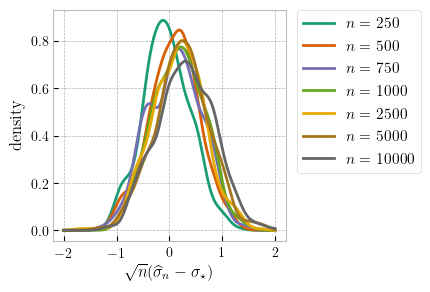

In [7]:
# We estimate the density of the centered and rescaled MSWE for sigma and we plot it
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 10
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [3, 3]

cm_subsection = np.linspace(0., 1., len_range_n) 
colors = [cm.Dark2(x) for x in cm_subsection]

for n in range(len_range_n):
    t = np.linspace(-2, 2, 1000)
    kde = gaussian_kde(normed_mse_sigma[n], bw_method=0.13 / normed_mse_sigma[n].std(ddof=1))
    plt.plot(t, kde.evaluate(t), label='$n =\ $' + str(range_n[n]), color=colors[n])
ax = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=11)
plt.xlabel('$\sqrt{n} (\widehat{\sigma}_n - \sigma_\star)$')
plt.ylabel('density')
        
# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'gaussian_rate_convergence.pdf')
fig.savefig(figpath)
plt.show()
plt.close()


### Illustration of the consistency of MSWE

For different values of $n$, we draw $n$ samples from the target distribution and we compute the (approximate) MSWE of order 2. We repeat this experiment several times and we report for each $n$ the average mean squared error between the estimate $(\hat{\mathbf{m}}_n, \hat{\sigma}_n)$ and the data-generating parameters $(\mathbf{m}_\star, \sigma_\star)$, and its standard deviation. 

In [8]:
# This function generates 'n_samples' observations from the target and returns the MSWE of order 2 
def compute_mswe(n_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators

    # Parameters of the target Gaussian distribution
    dim = 10  # dimension
    m_star = np.zeros(dim)  # true mean 
    sigma_star = 1.  # true sigma
    
    # Hyperparameters for the MSWE computation
    n_projections = 1  # number of directions of projections for the SW
    
    # Sample the target
    X = np.random.multivariate_normal(m_star, (sigma_star ** 2) * np.eye(dim), n_samples)
    
    # Compute the MSWE of order 1 and return the parameters found
    mswe_mean, mswe_sigma = estimators.compute_gaussian_mswe(X, n_projections, batch_size=n_samples, 
                                                             order=2, n_iterations=20000)
    return mswe_mean, mswe_sigma

In [9]:
# Initialization
range_n = [10, 50, 100, 500, 1000, 5000, 10000]  # different values of n
len_range_n = len(range_n)
n_exp = 100  # number of repetitions of the MSWE computation for each n

mswe_mean = np.zeros((len_range_n, n_exp, dim))
mswe_sigma = np.zeros((len_range_n, n_exp))

# For each n, we compute 'n_exp' times (in parallel) the MSWE of order 2
for k in range(len_range_n):
    print("Starting experiment for n=" + str(range_n[k]) + " samples...")
    params_list = [range_n[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_mswe, iter(params_list))
    stop = time()
    # Store the estimate
    mswe_mean[k] = np.array([i[0] for i in res])
    mswe_sigma[k] = np.array([i[1] for i in res])
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Compute the mean squared errors
mse_mean = ((mswe_mean - m_star)**2).mean(axis=2)
mse_sigma = (mswe_sigma - sigma_star)**2

Starting experiment for n=10 samples...
Done in 2.4602417230606077 min. 

Starting experiment for n=50 samples...
Done in 1.9995269815127055 min. 

Starting experiment for n=100 samples...
Done in 1.9921630183855692 min. 

Starting experiment for n=500 samples...
Done in 2.4914318323135376 min. 

Starting experiment for n=1000 samples...
Done in 2.0806414167086285 min. 

Starting experiment for n=5000 samples...
Done in 2.646617643038432 min. 

Starting experiment for n=10000 samples...
Done in 4.92694354057312 min. 



/usr/lib64/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


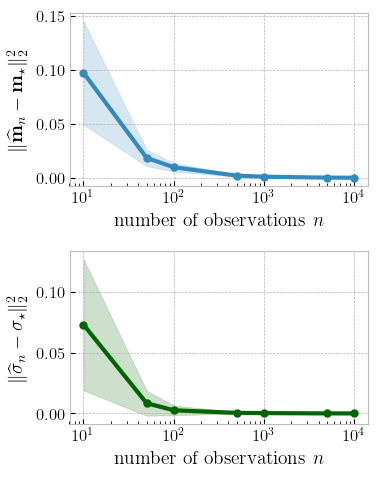

In [10]:
# Plot the average mean squared error and its standard deviation against n
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 12
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [4, 5]
lw = 3
ms = 5

plt.figure(1)

# Plot for the mean
plt.subplot(2, 1, 1)
plot_mu, = plt.semilogx(range_n, mse_mean.mean(axis=1), 'o-', lw=lw, ms=ms)
color = plot_mu.get_color()
plt.fill_between(range_n, mse_mean.mean(axis=1) - mse_mean.std(axis=1), 
                 mse_mean.mean(axis=1) + mse_mean.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of observations $n$')
plt.ylabel('$\| \widehat{\mathbf{m}}_n - \mathbf{m}_\star \|_2^2$')
plt.tight_layout()

# Plot for sigma
plt.subplot(2, 1, 2)
plot_sigma, = plt.semilogx(range_n, mse_sigma.mean(axis=1), 'o-', lw=lw, ms=ms, color='darkgreen')
color = plot_sigma.get_color()
plt.fill_between(range_n, mse_sigma.mean(axis=1) - mse_sigma.std(axis=1), 
                 mse_sigma.mean(axis=1) + mse_sigma.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of observations $n$')
plt.ylabel('$\| \widehat{\sigma}_n - \sigma_\star \|_2^2$')
plt.tight_layout()

# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'gaussian_consistency_mswe.pdf')
fig.savefig(figpath)
plt.show()
plt.close()


### Illustration of the consistency of MESWE

For different values of $n$, we draw $n$ samples from the target distribution and we compute the (approximate) MESWE of order 2, using one generated dataset of size $m = n$. We repeat this experiment several times and we report for each $n$ the average mean squared error between the estimate $(\hat{\mathbf{m}}_{n,n}, \hat{\sigma}_{n,n})$ and the data-generating parameters $(\mathbf{m}_\star, \sigma_\star)$, and its standard deviation. 

In [11]:
# This function generates 'n_samples' observations from the target and returns the MESWE of order 2, 
# where the expected SW distance is computed between the 'n_samples' observations and 
# 'n_montecarlo' generated datasets of size m = 'n_samples'.
def compute_meswe_m_equal_n(n_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators
    
    # Parameters of the target Gaussian distribution
    dim = 10  # dimension
    m_star = np.zeros(dim)  # true mean 
    sigma_star = 1.  # true sigma
    
    # Hyperparameters for the MESWE computation
    n_projections = 1  # number of directions of projections for the SW
    n_montecarlo = 1  # number of generated datasets
    
    # Sample the target
    X = np.random.multivariate_normal(m_star, (sigma_star**2)*np.eye(dim), n_samples)
    
    # Compute the MESWE of order 2 and return the parameters found
    meswe_mean, meswe_sigma = estimators.compute_meswe(X, n_montecarlo, n_samples, n_projections, 
                                                       batch_size=n_samples, distribution="gaussian", 
                                                       order=2, n_iterations=10000)
    return meswe_mean, meswe_sigma

In [12]:
# Initialization
range_nm = [10, 50, 100, 500, 1000, 5000, 10000]  # different values of n (= m)
len_range_nm = len(range_nm)
n_exp = 100  # number of repetitions of the MESWE computation for each n (= m)

meswe_mean = np.zeros((len_range_nm, n_exp, dim))
meswe_sigma = np.zeros((len_range_nm, n_exp))

# For each n (= m), we compute 'n_exp' times (in parallel) the MESWE of order 2
for k in range(len_range_nm):
    print("Starting experiment for n=m=" + str(range_nm[k]) + " samples...")
    params_list = [range_nm[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_meswe_m_equal_n, iter(params_list))
    stop = time()
    # Store the estimate
    meswe_mean[k] = np.array([i[0] for i in res])
    meswe_sigma[k] = np.array([i[1] for i in res])
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Compute the mean squared errors
mse_mean = ((meswe_mean - m_star)**2).mean(axis=2)
mse_sigma = (meswe_sigma - sigma_star)**2

Starting experiment for n=m=10 samples...
Done in 0.6753594239552816 min. 

Starting experiment for n=m=50 samples...
Done in 0.6972002267837525 min. 

Starting experiment for n=m=100 samples...
Done in 0.7327765941619873 min. 

Starting experiment for n=m=500 samples...
Done in 0.9453601757685344 min. 

Starting experiment for n=m=1000 samples...
Done in 1.22069650888443 min. 

Starting experiment for n=m=5000 samples...
Done in 3.5625147620836892 min. 

Starting experiment for n=m=10000 samples...
Done in 7.03796566327413 min. 



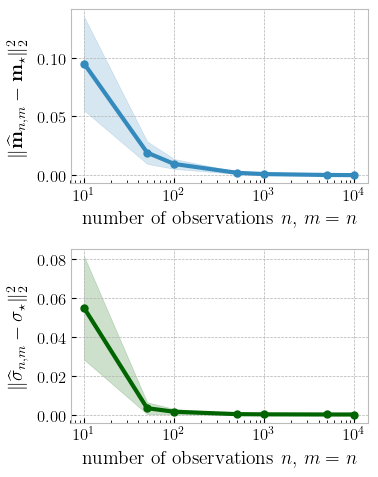

In [13]:
# Plot the average mean squared error and its standard deviation against n
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 12
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [4, 5]
lw = 3
ms = 5

plt.figure(2)

# Plot for the mean
plt.subplot(2, 1, 1)
plot_mu, = plt.semilogx(range_nm, mse_mean.mean(axis=1), 'o-', lw=lw, ms=ms)
color = plot_mu.get_color()
plt.fill_between(range_nm, mse_mean.mean(axis=1) - mse_mean.std(axis=1), 
                 mse_mean.mean(axis=1) + mse_mean.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of observations $n$, $m = n$')
plt.ylabel('$\| \widehat{\mathbf{m}}_{n,m} - \mathbf{m}_\star \|_2^2$')
plt.tight_layout()

# Plot for sigma
plt.subplot(2, 1, 2)
plot_sigma, = plt.semilogx(range_nm, mse_sigma.mean(axis=1), 'o-', lw=lw, ms=ms, color='darkgreen')
color = plot_sigma.get_color()
plt.fill_between(range_nm, mse_sigma.mean(axis=1) - mse_sigma.std(axis=1), 
                 mse_sigma.mean(axis=1) + mse_sigma.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of observations $n$, $m = n$')
plt.ylabel('$\| \widehat{\sigma}_{n,m} - \sigma_\star \|_2^2$')
plt.tight_layout()

# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'gaussian_consistency_meswe.pdf')
fig.savefig(figpath)
plt.show()
plt.close()


### Illustration of the convergence of MESWE to MSWE

We draw $n^* = 2000$ samples from the target distribution and we compute, on one hand, the MSWE of order 2, and on the other hand, the MESWE of order 2 using 'n_montecarlo' = 1 generated dataset of size $m$ for different values of $m$. We repeat this experiment several times and we report for each $m$ the average mean squared error between MESWE $(\hat{\mathbf{m}}_{n^*,m}, \hat{\sigma}_{n^*,m})$ and MSWE $(\hat{\mathbf{m}}_{n^*}, \hat{\sigma}_{n^*})$, and its standard deviation. 

In [17]:
# This function computes MSWE of order 2 for 'n_samples' = 2000 observations from the target,
# as well as MESWE of order 2, where the expected SW distance is computed between the 2000 
# observations and 'n_montecarlo' generated datasets of size m = 'n_gen_samples'.
def compute_meswe_m_different_n(n_gen_samples):
    # Imports
    import numpy as np
    import random
    seed = random.randrange(1000)
    np.random.seed(seed)
    import sys
    sys.path.append('code/')
    import estimators
    
    # Parameters of the target Gaussian distribution
    dim = 10  # dimension
    m_star = np.zeros(dim)  # true mean 
    sigma_star = 1.  # true sigma
    
    # Hyperparameters for the MESWE computation
    n_samples = 2000  # number of samples drawn from the target # CHANGE?
    n_projections = 1  # number of directions of projections for the SW
    n_montecarlo = 1  # number of generated datasets
    
    # Sample the target
    X = np.random.multivariate_normal(m_star, (sigma_star**2)*np.eye(dim), n_samples)
    
    # Compute the MESWE of order 2 and return the parameters found
    meswe_mean, meswe_sigma = estimators.compute_meswe(X, n_montecarlo, n_gen_samples, n_projections, 
                                                       batch_size=n_samples, distribution='gaussian', 
                                                       order=2, n_iterations=10000)
    
    # Compute the MSWE of order 2 and return the parameters found
    mswe_mean, mswe_sigma = estimators.compute_gaussian_mswe(X, n_projections, batch_size=n_samples, 
                                                             order=2, n_iterations=20000)
    return meswe_mean, mswe_mean, meswe_sigma, mswe_sigma

In [18]:
# Initialization
range_m = [10, 50, 100, 500, 1000, 5000, 10000]  # different values of m
len_range_nm = len(range_m)  
n_exp = 100  # number of repetitions of the MESWE computation for each m

meswe_mean = np.zeros((len_range_nm, n_exp, dim))
meswe_sigma = np.zeros((len_range_nm, n_exp))
mswe_mean = np.zeros((len_range_nm, n_exp, dim))
mswe_sigma = np.zeros((len_range_nm, n_exp))

# For each m, we compute 'n_exp' times (in parallel) MSWE and MESWE of order 2
for k in range(len_range_nm):
    print("Starting experiment for m=" + str(range_m[k]) + " samples...")
    params_list = [range_m[k]] * n_exp
    start = time()
    res = dv.map_sync(compute_meswe_m_different_n, iter(params_list))
    stop = time()
    # Store the estimate
    meswe_mean[k] = np.array([i[0] for i in res])
    mswe_mean[k] = np.array([i[1] for i in res])
    meswe_sigma[k] = np.array([i[2] for i in res])
    mswe_sigma[k] = np.array([i[3] for i in res])
    print("Done in " + str((stop - start) / 60.0) + " min. \n")

# Compute the mean squared errors
mse_mean = ((meswe_mean - mswe_mean)**2).mean(axis=2)
mse_sigma = (meswe_sigma - mswe_sigma)**2

Starting experiment for m=10 samples...
Done in 5.5398896137873335 min. 

Starting experiment for m=50 samples...
Done in 5.61859423716863 min. 

Starting experiment for m=100 samples...
Done in 5.0756760597229 min. 

Starting experiment for m=500 samples...
Done in 5.655779798825582 min. 

Starting experiment for m=1000 samples...
Done in 5.977520052591959 min. 

Starting experiment for m=5000 samples...
Done in 9.463922985394795 min. 

Starting experiment for m=10000 samples...
Done in 13.873770312468212 min. 



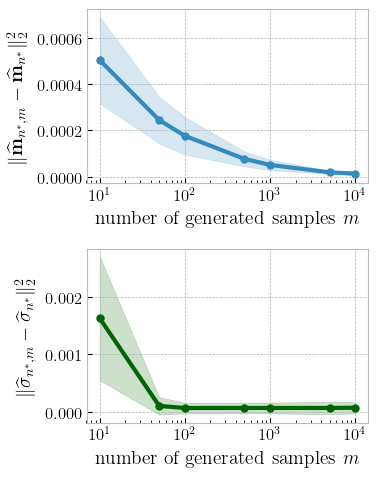

In [19]:
# Plot the average mean squared error and its standard deviation against m
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('bmh')
fontsize = 12
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True,
      'errorbar.capsize': 4}
plt.rcParams.update(params)
plt.rc('font', family='Times')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [4, 5]
lw = 3
ms = 5

plt.figure(3)

# Plot for the mean
plt.subplot(2, 1, 1)
plot_mu, = plt.semilogx(range_m, mse_mean.mean(axis=1), 'o-', lw=lw, ms=ms)
color = plot_mu.get_color()
plt.fill_between(range_m, mse_mean.mean(axis=1) - mse_mean.std(axis=1), 
                 mse_mean.mean(axis=1) + mse_mean.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of generated samples $m$')
plt.ylabel('$\| \widehat{\mathbf{m}}_{n^*,m} - \widehat{\mathbf{m}}_{n^*} \|_2^2$')
plt.tight_layout()

# Plot for sigma
plt.subplot(2, 1, 2)
plot_sigma, = plt.semilogx(range_m, mse_sigma.mean(axis=1), 'o-', lw=lw, ms=ms, color='darkgreen')
color = plot_sigma.get_color()
plt.fill_between(range_m, mse_sigma.mean(axis=1) - mse_sigma.std(axis=1), 
                 mse_sigma.mean(axis=1) + mse_sigma.std(axis=1), alpha=0.2, color=color)
plt.xlabel('number of generated samples $m$')
plt.ylabel('$\| \widehat{\sigma}_{n^*,m} - \widehat{\sigma}_{n^*} \|_2^2$')
plt.tight_layout()

# Save and show figure
fig = plt.gcf()
figpath = os.path.join('figures', 'gaussian_convergence_meswe_to_mswe.pdf')
fig.savefig(figpath)
plt.show()
plt.close()
